## Long-range CNOT gate teleportation using dynamic circuits

Based on paper: https://arxiv.org/abs/2308.13065

# Step 1: Map the problem to circuits and operators

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynamic_CNOT_circuit(num_qubits):
    """
        1d chain of nearest neighbours with 0th qubit being the CNOT control and the (num_qubits-1)th qubit being the target. Assume that the control qubit starts in the |+> state. 

        Parameters:
            num_qubits: The number of qubits in the 1d chain. 
    """
    num_ancilla = num_qubits-2
    num_ancilla_pairs = int(num_ancilla/2)

    qr = QuantumRegister(num_qubits)

    # Need three classical registers: one for the parity of a bit string for a controlled Z gate on the control qubit of the long-range CNOT (qubit 0); one for the parity of a 
    # second bit string for a controlled X gate on the target of the long-range CNOT (qubit num_qubits-1); and one to store the result of the measurement of the control and target
    # qubits of the long-range CNOT (qubits 0 and num_qubits-1).
    cr1 = ClassicalRegister(num_ancilla_pairs, name="cr1")     # The parity controlled X gate. 
    cr2 = ClassicalRegister(num_ancilla  - num_ancilla_pairs, name="cr2")       # The parity controlled Z gate. 
    cr3 = ClassicalRegister(2,name="cr3")       # The final measurements on the control and target qubits of the long-range CNOT. 

    # Initialise the circuit. 
    qc = QuantumCircuit(qr,cr1,cr2,cr3)

    # Initialise the control qubit in the + state. 
    qc.h(0)
    qc.barrier()

    # Entangle the control qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on the ancilla qubits from qubit 1 to num_qubits-2 (this is num_qubits-1-1)
    for i in range(num_ancilla_pairs):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)
    
    # Prepare Bell pairs on the staggered ancilla and data qubits
    for i in range(num_ancilla_pairs+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(1, num_ancilla_pairs+2):
        qc.h(2*i-1)

    # Now do mid-circuit measurements, store those measurements, do some logical processing on them, and then do conditional Z/X gates on the control and target qubits. 
    # First do measurements on alternating ancilla qubits, starting with the first one. Keep track of the parity for the eventual conditional Z gate. 
    for i in range(1, num_ancilla_pairs+2):
        qc.measure(2*i-1, cr2[i-1])
        # If i=1 then its the first measurement and the parity is easy to compute and is just the result of the measurement.
        if i==1:
            parity_control = expr.lift(cr2[i-1])        # Converts the scalar measurement into a logical expression. 
        else:
            # For the rest of the qubits, compare the parity of the new measurement with the parity_control bit; if they're the same then the parity is the same, if they're
            # different then the parity has changed. This is just a classical bit XOR. 
            parity_control = expr.bit_xor(cr2[i-1], parity_control)
    # Second, do measurements on alternating qubits, starting with the second one. Keep track of the parity for the eventual conditional X gate. 
    for i in range(num_ancilla_pairs):
        qc.measure(2*i+2, cr1[i])
        if i==0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    # Conditional Z(control) and X(target) gates
    with qc.if_test(parity_control):
        qc.z(0)
    with qc.if_test(parity_target):
        qc.x(-1)

    return qc


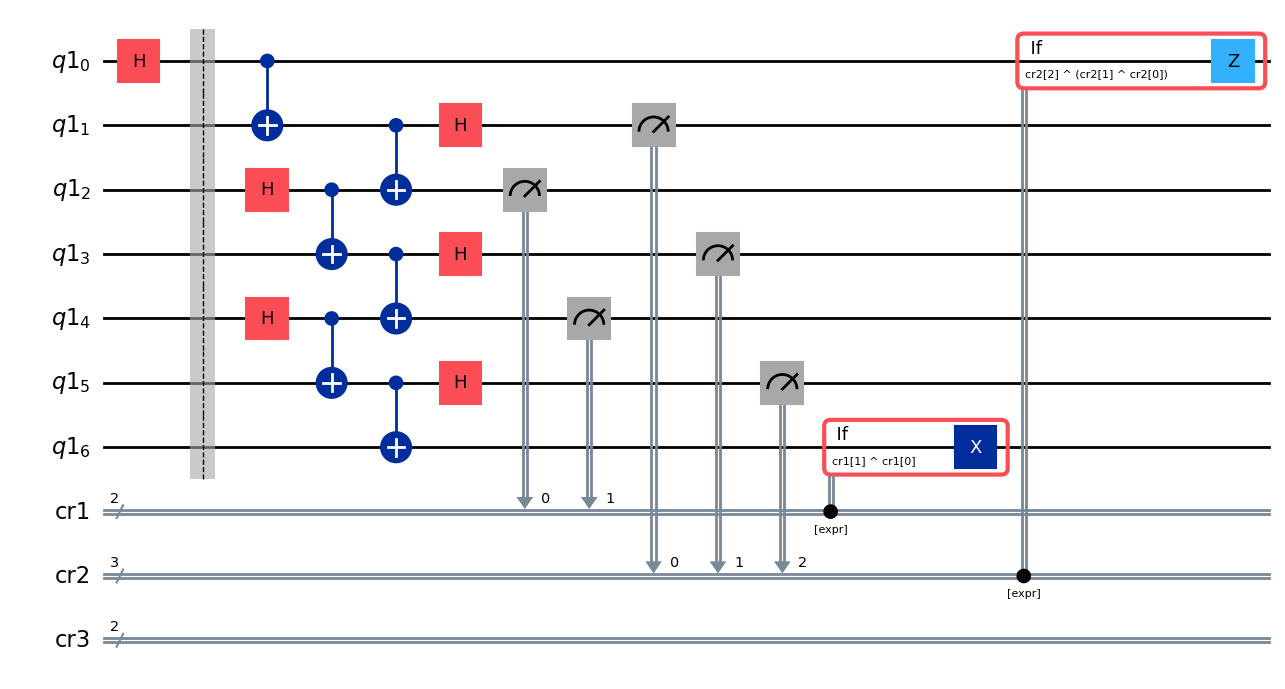

In [5]:
qc = get_dynamic_CNOT_circuit(num_qubits=7)
qc.draw(output='mpl')

In [8]:
# As the number of qubits between the control and target invcreases, we would expect the quality of the long-range CNOT to deteriorate due to noise coming from the growing 
# number of intermediary gates, so let's increase the number of qubits and see what happens. 

max_num_qubits = 41

qc_list = []
num_qubit_list = list(range(7,max_num_qubits+1,2))
for num_qubits in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubits))

# Step 2: Optimize the problem for quantum execution

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pass_manager.run(qc_list)

/var/folders/rr/zb03ch_925s5zfqc9w_mlvdh0000gn/T/ipykernel_14993/182649614.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


# Step 3: Execute the circuit 

In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

d0jdm78crrag008n5tv0


# Step 4: Post-processing and plotting 

In [23]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = "d0jdm78crrag008n5tv0"
service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []          # Probability of getting 00 or 11 on the control/target qubits of the long-range CNOT
list_other = []         # Probability of getting anything else. 
for i in range(0, len(qc_list)):
    data = result[i+1].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts['00']+counts['11']) / total_counts
    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other states')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()
plt.show()

/var/folders/rr/zb03ch_925s5zfqc9w_mlvdh0000gn/T/ipykernel_14993/2990218515.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


KeyError: '11'